# Instance Segmentation

- Если объекты не “касаются” и не перекрывают друг друга, их можно разделить
- Но так бывает не всегда

<img src="./img/comb_masks.ppm">

- Добавим в детектор объектов семантическую сегментацию для бокса вокруг каждого объекта

## Mask R-CNN (2017)

- <a href="https://paperswithcode.com/paper/mask-r-cnn">Mask R-CNN (2017)</a>
- В основе - Faster R-CNN
- Дополнительная ветвь для предсказания бинарной маски во всех proposals
- Маски не зависят от классов (т.е. сегментация на 1 класс)
- Вместо RoIPool — RoIAlign

<img src="./img/mask_rcnn.png">

- В Mask R-CNN используется операция RoIAlign: вместо грубого округления границ и пулинга значений используется интерполяция значений по сетке

<img src="./img/roi_align.png">

In [2]:
import torch
import torch.nn as nn
from torchvision.models.detection.mask_rcnn import maskrcnn_resnet50_fpn_v2

In [2]:
model = maskrcnn_resnet50_fpn_v2()

In [3]:
model.eval();

In [4]:
model(torch.rand(1, 3, 480, 640))

[{'boxes': tensor([[6.1559e+02, 4.2027e+02, 6.4000e+02, 4.2075e+02],
          [2.7607e+02, 9.8405e+01, 3.1026e+02, 9.8812e+01],
          [6.1283e+02, 3.5579e+02, 6.3871e+02, 3.5610e+02],
          [0.0000e+00, 2.0323e+01, 5.7498e+02, 2.2800e+01],
          [2.1118e+02, 1.9843e+01, 6.4000e+02, 2.2970e+01],
          [6.1163e+02, 2.8137e+02, 6.4000e+02, 2.8168e+02],
          [0.0000e+00, 1.9092e+01, 2.6600e+02, 2.1855e+01],
          [0.0000e+00, 8.0917e+00, 3.3582e+02, 1.1736e+01],
          [3.8213e+00, 1.5625e+01, 5.0131e+02, 1.8273e+01],
          [7.1967e+00, 2.3349e+01, 5.2017e+02, 2.5705e+01],
          [0.0000e+00, 5.7343e+00, 2.7185e+02, 9.1125e+00],
          [0.0000e+00, 1.8124e+01, 3.8299e+02, 2.1308e+01],
          [0.0000e+00, 1.8592e+00, 5.4723e+02, 5.3372e+00],
          [1.7067e+02, 3.8817e+02, 2.0382e+02, 3.8872e+02],
          [0.0000e+00, 2.2451e+01, 3.9736e+02, 2.4966e+01],
          [0.0000e+00, 2.4263e+01, 4.2138e+02, 2.6798e+01],
          [2.1355e+02, 1.4653e+

In [5]:
model.forward?

Signature: model.forward(images, targets=None)
Docstring:
Args:
    images (list[Tensor]): images to be processed
    targets (list[Dict[str, Tensor]]): ground-truth boxes present in the image (optional)

Returns:
    result (list[BoxList] or dict[Tensor]): the output from the model.
        During training, it returns a dict[Tensor] which contains the losses.
        During testing, it returns list[BoxList] contains additional fields
        like `scores`, `labels` and `mask` (for Mask R-CNN models).
File:      ~/miniconda3/envs/mlisuct/lib/python3.8/site-packages/torchvision/models/detection/generalized_rcnn.py
Type:      method


# Проблемы с памятью

- Модели для сегментации (и не только) могут быть прожорливы по памяти по сравнению с классификацией
-- Больше карт активаций (encoder + decoder)
-- Больше HW 
- Увеличивается потребление памяти на 1 пример -> уменьшается размер батча
- Малый размер батча
-- Шумные градиенты
-- Проблемы с BatchNorm


## Шумные градиенты для малых батчей

- <a href="https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/02/19/gradient-accumulation.html">Gradient Accumulation</a>
- Накапливание градиентов по нескольким батчам перед обновлением весов


In [6]:
# batch accumulation parameter
accum_iter = 4

# loop through enumaretad batches
for batch_idx, (inputs, labels) in enumerate(data_loader):

    # extract inputs and labels
    inputs = inputs.to(device)
    labels = labels.to(device)
        
    # forward pass 
    preds = model(inputs)
    loss  = criterion(preds, labels)

    # normalize loss to account for batch accumulation
    loss = loss / accum_iter 

    # backward pass
    loss.backward()

    # weights update
    if ((batch_idx + 1) % accum_iter == 0) or (batch_idx + 1 == len(data_loader)):
        optimizer.step()
        optimizer.zero_grad()

NameError: name 'data_loader' is not defined

## Проблемы с BatchNorm

- BN вычисляет статистики по батчу
- Попался выброс в малом батче - сильно смещаются статистики
- Решение
-- Не использовать BN (-> InstanceNorm, …)
-- Использовать много GPU + SynchronizedBN
-- Если делаете fine-tuning: заморозить слои BN
-- Оптимизировать вычисления для BN


In [3]:
nn.InstanceNorm2d?

Init signature:
nn.InstanceNorm2d(
    num_features: int,
    eps: float = 1e-05,
    momentum: float = 0.1,
    affine: bool = False,
    track_running_stats: bool = False,
    device=None,
    dtype=None,
) -> None
Docstring:     
Applies Instance Normalization over a 4D input (a mini-batch of 2D inputs
with additional channel dimension) as described in the paper
`Instance Normalization: The Missing Ingredient for Fast Stylization
<https://arxiv.org/abs/1607.08022>`__.

.. math::

    y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta

The mean and standard-deviation are calculated per-dimension separately
for each object in a mini-batch. :math:`\gamma` and :math:`\beta` are learnable parameter vectors
of size `C` (where `C` is the input size) if :attr:`affine` is ``True``.
The standard-deviation is calculated via the biased estimator, equivalent to
`torch.var(input, unbiased=False)`.

By default, this layer uses instance statistics computed from input 

### Оптимизация вычислений batch norm

Recap:

<img src="./img/batch_normalization.png">

- Для обновления параметров слоя требуется хранить тензор x после forward pass в буфере
- При backward pass значение x извлекается из буфера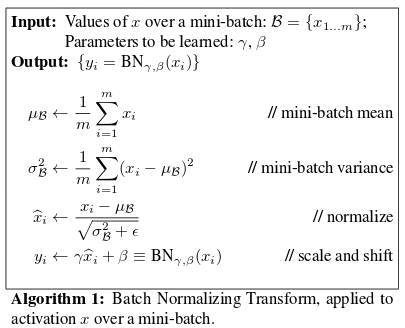
- Есть подходы, избавляющие от этой необходимости


### Inplace-ABN (2018)

- <a href="https://paperswithcode.com/paper/in-place-activated-batchnorm-for-memory">In-Place Activated BN for Memory-Optimized Training of DNNs</a>
- Рассмотрим связку BN + Activation + Conv

<img src="./img/stand_build_block.png">

- Для backward pass необходимо хранить только промежуточные тензоры x, z
-- Для обратимых активаций вроде Sigmoid/Tanh y восстанавливается по z
-- Для ReLU по z нельзя восстановить y, но легко восстановить градиент dz/dy



- Если после forward pass буферизовать только x, то по сохраненным статистикам BN можно вычислить заново y и затем z 
- Меньше памяти, больше вычислений
- Нелокальность вычислений
- <a href="https://pytorch.org/docs/stable/checkpoint.html">Pytorch Checkpointing Doc</a>

<img src="./img/check_build_block.png">

- Будем использовать только обратимые активации (LeakyReLu вместо ReLu)
- Тогда можно при forward pass хранить только z
- Вычисления теперь локальны 

<img src="./img/inb_prop_block.png">

- Заявленная авторами экономия памяти GPU: до 50%
- Можно комбинировать с <a href="https://github.com/mapillary/inplace_abn/blob/main/inplace_abn/abn.py">SyncBN</a>

In [4]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-4yxifw_m
  Running command git clone -q https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-4yxifw_m
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36620 sha256=eb385572e0dc97f6dad6504a691d38a13a888f7ed3f75f2753614a3f3d8d8cb0
  Stored in directory: /tmp/pip-ephem-wheel-cache-0clw59fh/wheels/b0/7e/40/20f0b1e23280cc4a66dc8009c29f42cb4afc1b205bc5814786
Successfully built segment-anything


In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [6]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [7]:
image = cv2.imread('img/capcakes.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

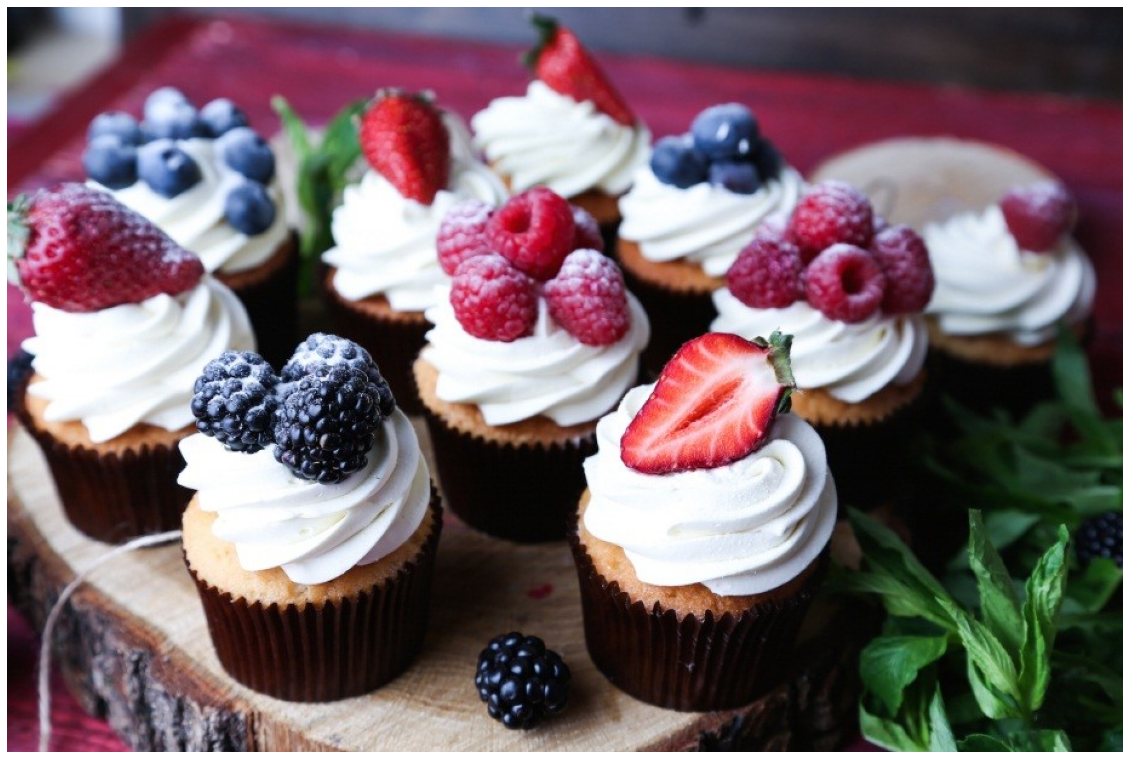

In [8]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [9]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_l_0b3195.pth"
model_type = "vit_l"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [11]:
masks = mask_generator.generate(image)

In [12]:
masks

[{'segmentation': array([[False, False, False, ...,  True,  True,  True],
         [False, False, False, ...,  True,  True,  True],
         [False, False, False, ...,  True,  True,  True],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 31403,
  'bbox': [96, 0, 824, 77],
  'predicted_iou': 1.0276864767074585,
  'point_coords': [[388.546875, 28.828125]],
  'stability_score': 0.9739655256271362,
  'crop_box': [0, 0, 921, 615]},
 {'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 4700,
  'bbox': [386, 516, 

In [13]:
print(len(masks))

127


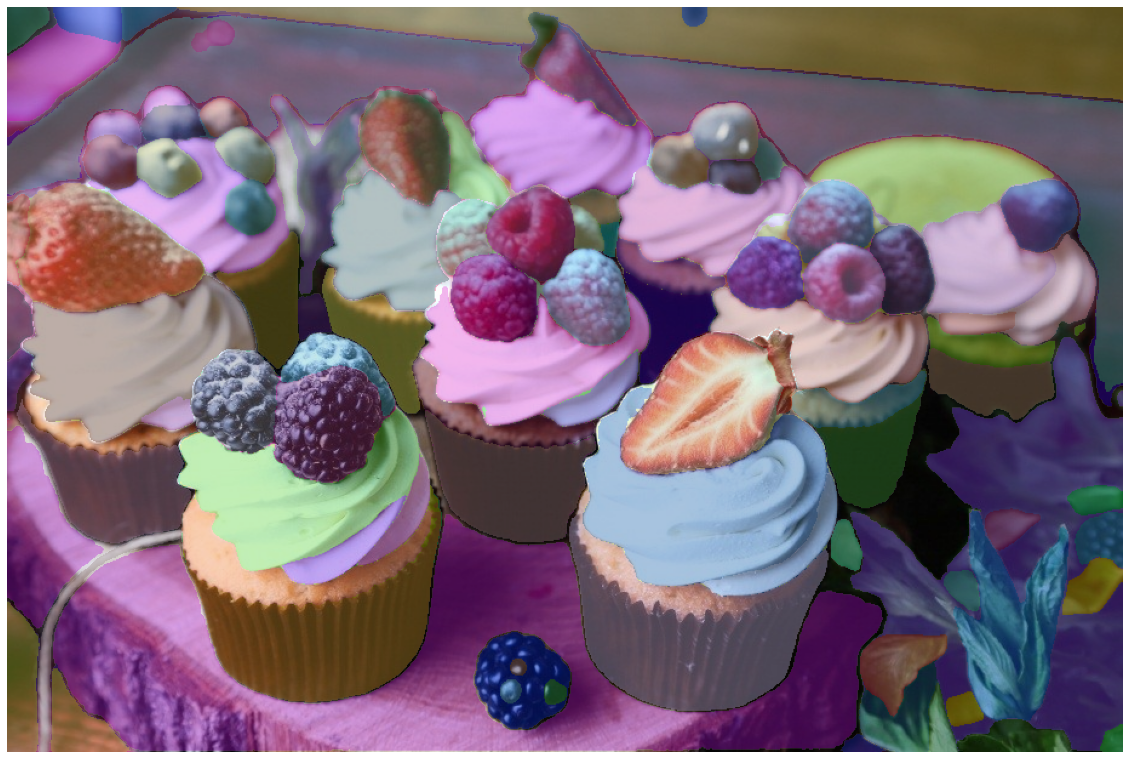

In [14]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()